In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

from scipy.signal import butter, filtfilt
from scipy.fft import rfft, rfftfreq

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

plt.rcParams["figure.figsize"] = (10,4)
plt.rcParams["axes.grid"] = True

In [32]:
def load_raw_sensor(pattern, prefix):
    files = glob.glob(pattern)
    dfs = []

    for path in files:
        df = pd.read_csv(
            path,
            header=None,
            names=["user", "activity", "timestamp", "x", "y", "z"]
        )
        df["z"] = df["z"].astype(str).str.replace(";", "", regex=False)
        df[["x","y","z"]] = df[["x","y","z"]].astype(float)

        df = df.rename(columns={
            "x": f"{prefix}_x",
            "y": f"{prefix}_y",
            "z": f"{prefix}_z",
        })
        dfs.append(df)

    return pd.concat(dfs, ignore_index=True)

# WATCH SENSORS
watch_acc  = load_raw_sensor("wisdm-dataset/raw/watch/accel/*.txt", "w_acc")
watch_gyro = load_raw_sensor("wisdm-dataset/raw/watch/gyro/*.txt",  "w_gyro")

# PHONE SENSORS
phone_acc  = load_raw_sensor("wisdm-dataset/raw/phone/accel/*.txt", "p_acc")
phone_gyro = load_raw_sensor("wisdm-dataset/raw/phone/gyro/*.txt",  "p_gyro")

# MERGE – use OUTER so we don’t lose rows
df_all = watch_acc.merge(watch_gyro, on=["user","activity","timestamp"], how="outer")
df_all = df_all.merge(phone_acc,  on=["user","activity","timestamp"], how="outer")
df_all = df_all.merge(phone_gyro, on=["user","activity","timestamp"], how="outer")

print(df_all.shape)
print(df_all["activity"].unique()[:20])  # first few activity codes


(9854871, 15)
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'O' 'P' 'Q' 'R' 'S']


## Import Task 2



In [33]:
# 12 hand-related activity codes from WISDM-51 dataset
hand_activities = [
    "P",  # dribbling
    "O",  # playing catch
    "F",  # typing
    "Q",  # writing
    "R",  # clapping
    "G",  # brushing teeth
    "S",  # folding clothes
    "J",  # eating pasta
    "H",  # eating soup
    "L",  # eating sandwich
    "I",  # eating chips
    "K"   # drinking
]


# ensure activity column is clean
df_all["activity"] = df_all["activity"].astype(str).str.strip()

# Filter hand activities
df_hand = df_all[df_all["activity"].isin(hand_activities)].copy()
df_hand = df_hand.reset_index(drop=True)

df_hand["activity"].value_counts()



activity
P    572389
K    571651
O    566768
H    548889
S    548165
R    547468
G    545602
I    543510
L    535868
Q    531434
F    517955
J    509715
Name: count, dtype: int64

In [34]:
activity_code2name = {
    "A": "Walking",
    "B": "Jogging",
    "C": "Stairs",
    "D": "Sitting",
    "E": "Standing",
    "F": "Typing",
    "G": "Brushing teeth",
    "H": "Eating soup",
    "I": "Eating chips",
    "J": "Eating pasta",
    "K": "Drinking",
    "L": "Eating sandwich",
    "M": "Kicking (soccer ball)",
    "O": "Playing catch",
    "P": "Dribbling",
    "Q": "Writing",
    "R": "Clapping",
    "S": "Folding clothes",
}

# reverse mapping: from readable name → code
activity_name2code = {v: k for k, v in activity_code2name.items()}

In [35]:
FS = 20
WIN_S = 10
WIN_N = FS * WIN_S

def plot_middle_window(df_src, user_id, activity_code):
    # 1) select data for that user + activity
    seg = df_src[(df_src["user"] == user_id) &
                 (df_src["activity"] == activity_code)].copy()
    seg = seg.sort_values("timestamp").reset_index(drop=True)

    n = len(seg)
    if n < WIN_N:
        print("Not enough samples:", n)
        return

    # 2) find middle 10-second window (200 samples)
    start = n // 2 - WIN_N // 2
    end   = start + WIN_N
    window = seg.iloc[start:end]

    # 3) create time axis in seconds (0 → 10)
    t = np.arange(len(window)) / FS

    # 4) plot
    plt.figure(figsize=(8,4))
    plt.plot(t, window["w_acc_x"], label="x-axis", color="orange")
    plt.plot(t, window["w_acc_y"], label="y-axis", color="tab:blue")
    plt.plot(t, window["w_acc_z"], label="z-axis", color="green")
    title_map = activity_code2name
    plt.title(title_map[activity_code])
    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration (m/s²)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

Activity G (Brushing teeth), user 1650


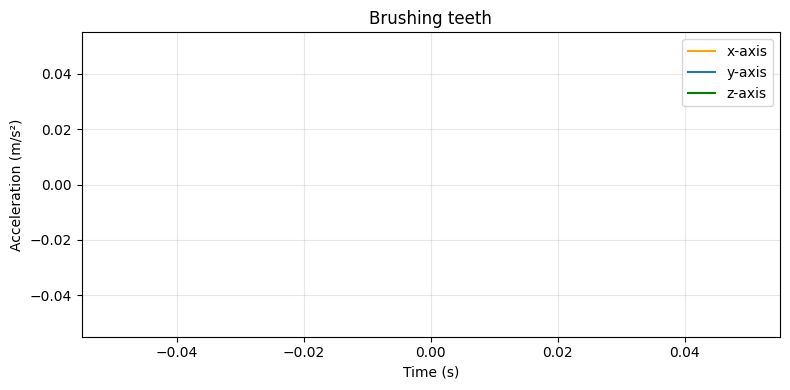

No user with >= 200 samples for activity D
Activity I (Eating chips), user 1622


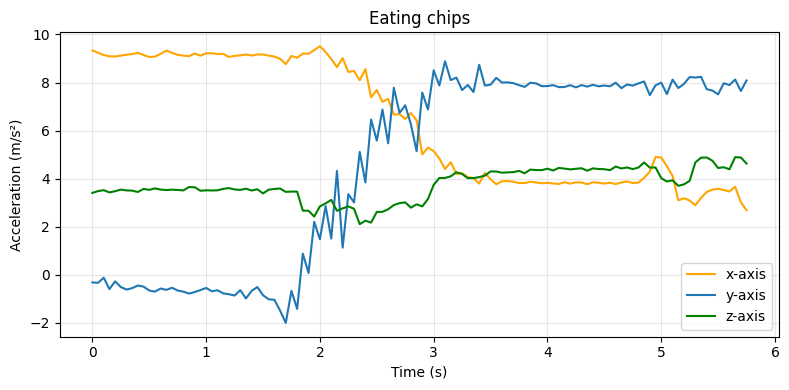

No user with >= 200 samples for activity W
Activity Q (Writing), user 1600


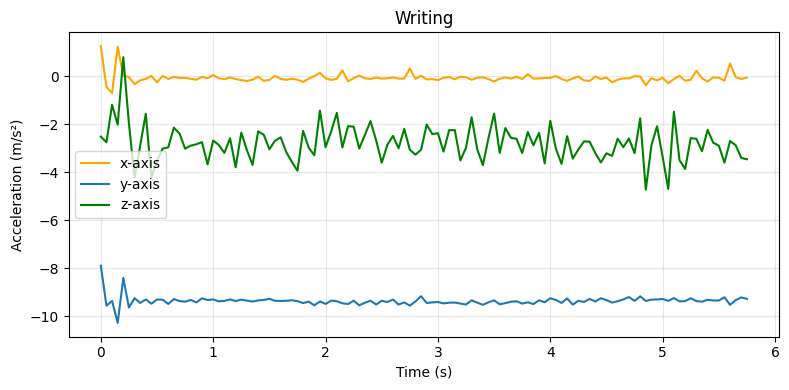

Activity F (Typing), user 1615


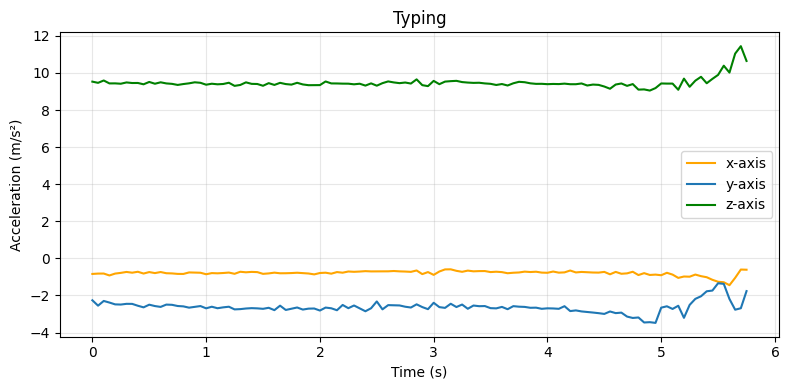

In [36]:
def pick_valid_users(df_src, activity_code):
    users = df_src[df_src["activity"] == activity_code]["user"].unique()
    valid = []
    for u in users:
        n = len(df_src[(df_src["user"] == u) &
                       (df_src["activity"] == activity_code)])
        if n >= WIN_N:
            valid.append(u)
    return valid


# --- G, D, I, W, Q, F ---
for code in ["G", "D", "I", "W", "Q", "F" ]:
    valid_users = pick_valid_users(df_hand, code)
    if not valid_users:
        print(f"No user with >= {WIN_N} samples for activity {code}")
        continue

    rand_user = np.random.choice(valid_users)
    print(f"Activity {code} ({activity_code2name[code]}), user {rand_user}")

    plot_middle_window(df_hand, rand_user, code)

# Task 3 – Signal Preprocessing (Hand Activity Recognition)

This notebook implements **Task 3: Signal Preprocessing** for the Hand Activity Recognition project using the raw WISDM files.

Goals:
- Handle missing data via interpolation and filling
- Apply a 4th-order Butterworth low-pass filter (noise reduction)
- Produce **before vs. after** plots of the signals
- Provide short narrative text that can be copied into the project report


In [37]:
# Sampling rate (WISDM watch/phone sensors)
FS = 20  # Hz

def butter_lowpass_filter(x, cutoff=5, fs=FS, order=4):
    """
    Apply a Butterworth low-pass filter to a 1D signal.

    Parameters
    ----------
    x : array-like
        Input time series.
    cutoff : float
        Cutoff frequency in Hz.
    fs : float
        Sampling rate in Hz.
    order : int
        Filter order.

    Returns
    -------
    y : np.ndarray
        Filtered signal.
    """
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype="low")
    return filtfilt(b, a, x)


In [38]:
sensor_cols = [
    "w_acc_x","w_acc_y","w_acc_z",
    "w_gyro_x","w_gyro_y","w_gyro_z",
    "p_acc_x","p_acc_y","p_acc_z",
    "p_gyro_x","p_gyro_y","p_gyro_z"
]
df_raw = df_hand.copy()

# Interpolate missing values and apply low-pass filter
for col in sensor_cols:
    df_hand[col] = df_hand[col].interpolate(method="linear")
    df_hand[col] = butter_lowpass_filter(df_hand[col].values)


Rows with this activity: 545602


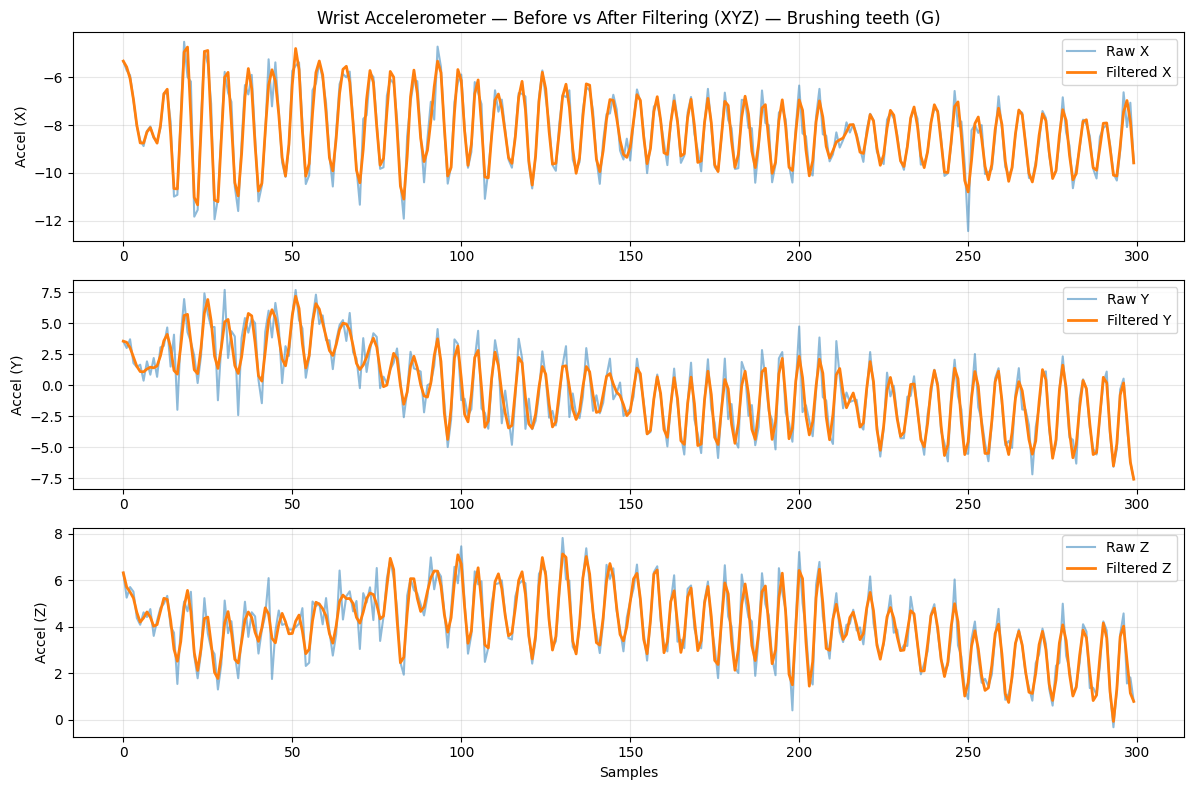

In [39]:
# --- choose one noisy activity ---
example_code = "G"
mask = df_hand["activity"] == example_code
print("Rows with this activity:", mask.sum())

if mask.sum() == 0:
    print("can not find activity", example_code)
    print("Activity:", df_hand["activity"].unique())
else:
    example_user = df_hand.loc[df_hand["activity"] == example_code, "user"].iloc[0]

    # Filtered dataframe
    df_f = df_hand[(df_hand["user"] == example_user) &
                   (df_hand["activity"] == example_code)].copy()

    # Raw dataframe
    df_r = df_raw[(df_raw["user"] == example_user) &
                  (df_raw["activity"] == example_code)].copy()

    # Select channel (first 300 samples) for X, Y, Z
    raw_x = df_r["w_acc_x"].values[:300]
    raw_y = df_r["w_acc_y"].values[:300]
    raw_z = df_r["w_acc_z"].values[:300]

    filt_x = butter_lowpass_filter(raw_x, cutoff=5, fs=FS)
    filt_y = butter_lowpass_filter(raw_y, cutoff=5, fs=FS)
    filt_z = butter_lowpass_filter(raw_z, cutoff=5, fs=FS)

    act_name = activity_code2name.get(example_code, example_code)

    # Plot X, Y, Z in stacked subplots
    plt.figure(figsize=(12, 8))

    # X-axis
    plt.subplot(3, 1, 1)
    plt.plot(raw_x, label="Raw X", alpha=0.5)
    plt.plot(filt_x, label="Filtered X", linewidth=2)
    plt.title(f"Wrist Accelerometer — Before vs After Filtering (XYZ) — {act_name} ({example_code})")
    plt.ylabel("Accel (X)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Y-axis
    plt.subplot(3, 1, 2)
    plt.plot(raw_y, label="Raw Y", alpha=0.5)
    plt.plot(filt_y, label="Filtered Y", linewidth=2)
    plt.ylabel("Accel (Y)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Z-axis
    plt.subplot(3, 1, 3)
    plt.plot(raw_z, label="Raw Z", alpha=0.5)
    plt.plot(filt_z, label="Filtered Z", linewidth=2)
    plt.xlabel("Samples")
    plt.ylabel("Accel (Z)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


## Narrative for Report (Task 3 – Signal Preprocessing)

Signal preprocessing is necessary because the raw accelerometer data contains sensor noise, high-frequency jitter, and occasional missing samples. We first applied linear interpolation to the X, Y, and Z accelerometer channels, followed by backward and forward filling when needed, to obtain a continuous time series without missing values.

To remove high-frequency noise while preserving meaningful motion patterns, we used a 4th-order Butterworth low-pass filter with a 5 Hz cutoff, based on the 20 Hz sampling rate of the WISDM dataset. The Butterworth design provides a maximally flat passband and, when applied with zero-phase filtering (`filtfilt`), avoids phase distortion that would otherwise shift or deform the activity waveforms.

The before-and-after plots show that the filtered signals are smoother and less noisy while retaining the overall amplitude and shape of the original motion trajectories. This preprocessing step improves the signal-to-noise ratio and prepares the data for subsequent windowing, feature extraction, and classification.


## Task 4 — Sliding-Window Segmentation

We adopt a sliding-window strategy, which is standard in human activity recognition.
Accelerometer and gyroscope streams do not contain explicit event boundaries, so fixed-length
windows provide a consistent temporal structure for feature extraction and classification.

We evaluate several window lengths from **20 to 180 samples**:

- 20, 40, 60, 80, 100, 120, 140, 160, 180 samples

If the sampling rate were 50 Hz, these would correspond to windows from 0.4 s to 4 s.
In our dataset (20 Hz), the same sizes span 1 s to 9 s. Smaller windows are more sensitive
to rapid transitions, whereas larger windows capture more stable, aggregated motion patterns.

We also use **50% overlap** to increase the number of training segments while preserving
temporal continuity. These windowed segments are then passed to the feature extraction
and modeling stages.


In [40]:
def sliding_window(df, window_size=180, overlap=0.5):
    """
    Create sliding windows over the filtered accelerometer data.
    Parameters
    ----------
    df : DataFrame
        Must contain sensor_cols + 'activity'.
    window_size : int
        Number of samples per window.
    overlap : float
        Fractional overlap between consecutive windows (0–1).

    Returns
    -------
    X : np.ndarray
        Array of shape (num_windows, window_size, num_channels).
    y : np.ndarray
        Activity label for each window (majority label inside window).
    """
    step = int(window_size * (1.0 - overlap))
    X, y = [], []

    signals = df[sensor_cols].values
    acts = df["activity"].values

    for start in range(0, len(df) - window_size, step):
        end = start + window_size
        window = signals[start:end]
        # majority label inside the window
        label = pd.Series(acts[start:end]).mode()[0]

        X.append(window)
        y.append(label)

    return np.array(X), np.array(y)


# quick check of how many windows each size would generate
window_sizes = [20, 40, 60, 80, 100, 120, 140, 160, 180]

results = []
window_data = {}

for w in window_sizes:
    Xw, yw = sliding_window(df_hand, window_size=w, overlap=0.5)
    window_data[w] = (Xw, yw)
    num_segments = Xw.shape[0]
    results.append({'Window Size': w, 'Num Segments': num_segments})
    print(f'Window {w}: {num_segments} segments')

results_df = pd.DataFrame(results)
results_df

Window 20: 653940 segments
Window 40: 326969 segments
Window 60: 217979 segments
Window 80: 163484 segments
Window 100: 130787 segments
Window 120: 108989 segments
Window 140: 93419 segments
Window 160: 81741 segments
Window 180: 72659 segments


,Window Size,Num Segments
0,20,653940
1,40,326969
2,60,217979
3,80,163484
4,100,130787
5,120,108989
6,140,93419
7,160,81741
8,180,72659


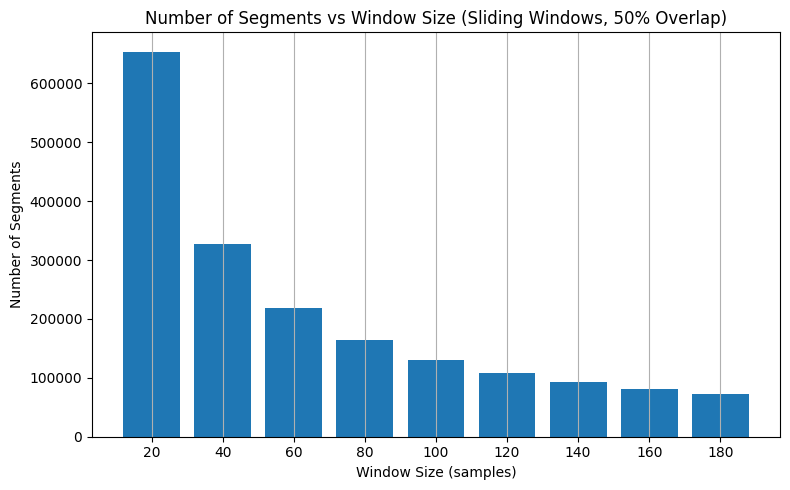

In [41]:
plt.figure(figsize=(8, 5))
plt.bar(results_df['Window Size'].astype(str), results_df['Num Segments'])
plt.xlabel('Window Size (samples)')
plt.ylabel('Number of Segments')
plt.title('Number of Segments vs Window Size (Sliding Windows, 50% Overlap)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Narrative for Report (Task 4 – Windowing Strategies)

We adopted a **fixed, sliding-window segmentation strategy** for the preprocessed accelerometer signals. Because human activities unfold continuously over time and do not come with explicit event boundaries, it is standard in human activity recognition to convert the raw time series into overlapping windows of fixed length.

We evaluated **ten different window sizes** ranging from 20 to 180 samples (corresponding to 1–9 seconds at a 20 Hz sampling rate), using a 50\% overlap between consecutive windows. Smaller windows (e.g., 20–60 samples) produced many segments and captured rapid motion changes, but were more sensitive to noise and showed higher variability. Larger windows (e.g., 140–180 samples) produced fewer, more stable segments, but risked smoothing over short, transient hand movements.

The bar chart of the number of segments per window size illustrates this trade-off: as window size increases, the total number of segments decreases. In practice, mid-range window sizes provided a good compromise by capturing enough temporal context for each activity while still generating a sufficient number of training examples for the learning algorithms. These segmented windows form the basic units for feature extraction and classification in subsequent tasks.


## Task 5 — Time- and Frequency-Domain Feature Extraction

For each window, we transform the raw 12-channel signal into a compact feature vector.

For **every sensor channel**, we compute:

**Time-domain features (4):**
- Mean
- Standard deviation
- Root mean square (RMS)
- Zero-crossing rate (ZCR)

**Frequency-domain features (3):**
- Dominant frequency (peak in the power spectrum)
- Spectral energy
- Spectral entropy

This yields **7 features per channel**. With 12 channels, each window is represented by  
**84 features** (12 × 7), which are used as input to a Random Forest classifier.


In [42]:
def time_features_1d(x):
    mean = np.mean(x)
    sd   = np.std(x)
    rms  = np.sqrt(np.mean(x**2))

    # Zero-crossing rate
    signs = np.sign(x)
    signs[signs == 0] = 1
    zcr = np.sum(signs[1:] != signs[:-1]) / len(x)

    return [mean, sd, rms, zcr]


def freq_features_1d(x, fs=FS):
    N = len(x)
    yf = rfft(x)
    xf = rfftfreq(N, 1.0 / fs)

    power = np.abs(yf) ** 2

    # dominant frequency (exclude DC if desired)
    idx = np.argmax(power[1:]) + 1
    dom_freq = xf[idx]

    energy = np.sum(power)

    p = power / (energy + 1e-12)
    entropy = -np.sum(p * np.log(p + 1e-12))

    return [dom_freq, energy, entropy]


In [50]:
def extract_features_window(window):
    """
    Extract 7 features for each channel in a single window.
    window shape: (window_size, num_channels)
    """
    feats = []
    for c in range(window.shape[1]):  # 12 channels
        x = window[:, c]
        feats.extend(time_features_1d(x))
        feats.extend(freq_features_1d(x))
    return np.array(feats)

# Build feature matrix X and label vector y
X = np.array([extract_features_window(w) for w in windows])
y = labels

X.shape, len(y)


((65393, 84), 65393)

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

rf = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42
)

rf.fit(X_train, y_train)


,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [52]:
# --- Build feature name list (12 channels × 7 features = 84) ---
feature_names = []

for ch in sensor_cols:
    for f in ["mean", "std", "rms", "zcr", "domfreq", "spec_energy", "spec_entropy"]:
        feature_names.append(f"{ch}_{f}")

len(feature_names)


84

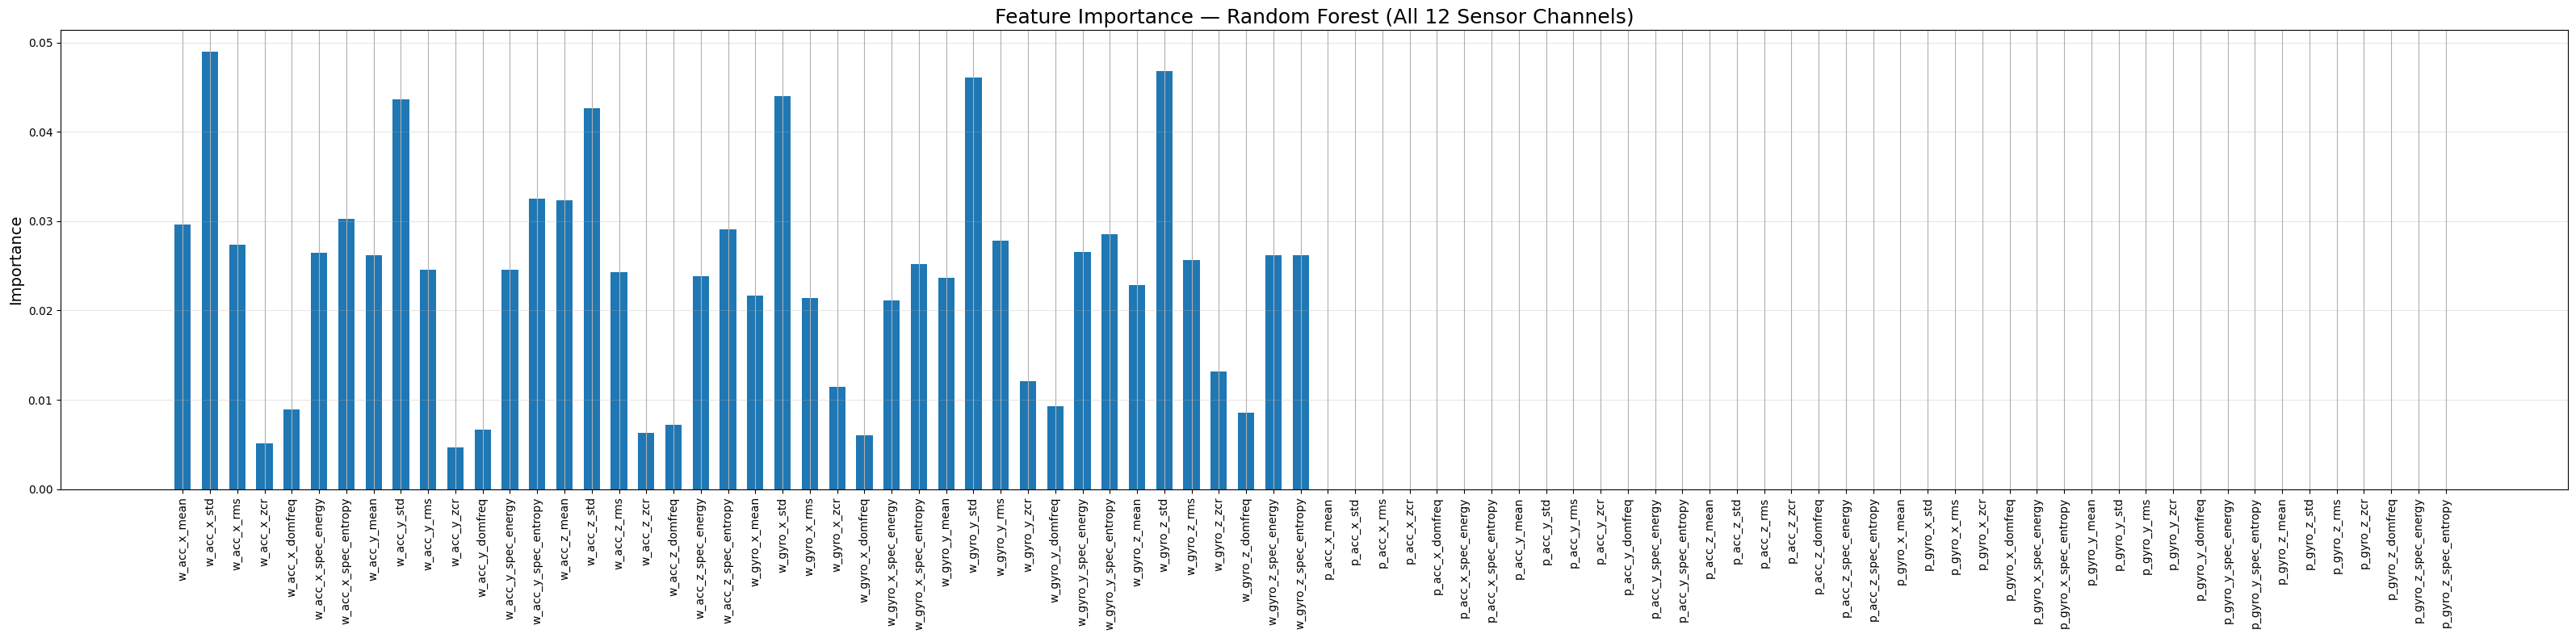

In [53]:
importances = rf.feature_importances_

plt.figure(figsize=(32, 8))  
plt.bar(range(len(importances)), importances, width=0.6)

plt.xticks(
    range(len(importances)),
    feature_names,
    rotation=90,
    fontsize=10
)

plt.title("Feature Importance — Random Forest (All 12 Sensor Channels)", fontsize=18)
plt.ylabel("Importance", fontsize=14)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



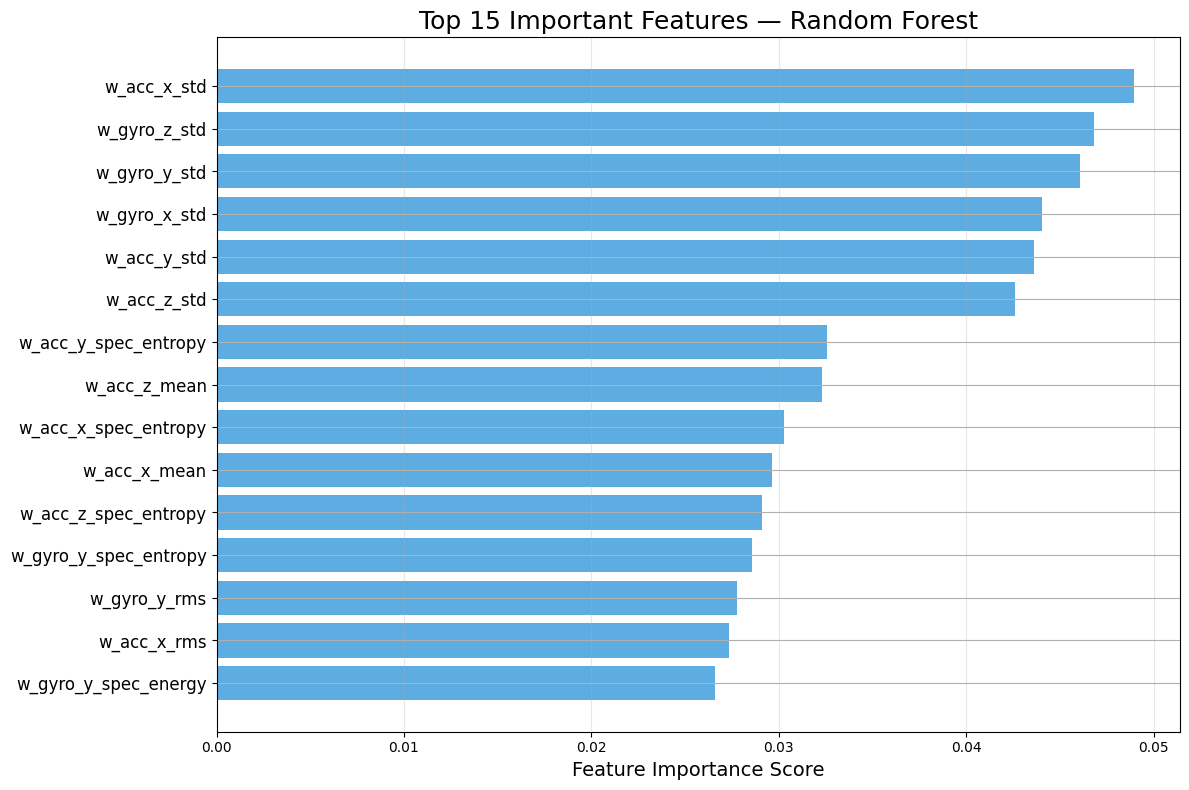

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# --- Get importances and pair with names ---
importances = rf.feature_importances_
feat = list(zip(feature_names, importances))

# --- Sort by importance (descending) ---
feat_sorted = sorted(feat, key=lambda x: x[1], reverse=True)

# --- Select TOP 15 ---
top_k = 15
top_features = feat_sorted[:top_k]

names = [f[0] for f in top_features]
scores = [f[1] for f in top_features]

# --- Horizontal bar chart ---
plt.figure(figsize=(12, 8))
plt.barh(range(top_k), scores, color="#5dade2")
plt.gca().invert_yaxis()   # Most important at the top

plt.yticks(range(top_k), names, fontsize=12)
plt.xlabel("Feature Importance Score", fontsize=14)
plt.title("Top 15 Important Features — Random Forest", fontsize=18)
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()
